<a href="https://colab.research.google.com/github/maggieliuzzi/reinforcement_learning/blob/master/temporal_difference/prediction/Approximation_Semi_Gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Temporal Difference** | Prediction Problem | TD(0) with Approximation, Semi-Gradient

In [0]:
from __future__ import print_function, division
from builtins import range
import matplotlib.pyplot as plt
import numpy as np
!wget "https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/rl/grid_world.py"
from grid_world import standard_grid, negative_grid
!wget "https://raw.githubusercontent.com/maggieliuzzi/reinforcement_learning/master/environments/utils.py"
from utils import print_values, print_policy

In [0]:
SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

In [0]:
def random_action(a, eps=0.1):
  # we'll use epsilon-soft to ensure all states are visited
  # what happens if you don't do this? i.e. eps=0
  p = np.random.random()
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [0]:
def play_game(grid, policy):
  # returns a list of states and corresponding rewards (not returns as in MC)
  # start at the designated start state
  s = (2, 0)
  grid.set_state(s)
  states_and_rewards = [(s, 0)] # list of tuples of (state, reward)
  while not grid.game_over():
    a = policy[s]
    a = random_action(a)
    r = grid.move(a)
    s = grid.current_state()
    states_and_rewards.append((s, r))
    
  return states_and_rewards

In [0]:
class Model:
  def __init__(self):
    self.theta = np.random.randn(4) / 2
  
  def s2x(self, s):
    return np.array([s[0] - 1, s[1] - 1.5, s[0]*s[1] - 3, 1])

  def predict(self, s):
    x = self.s2x(s)
    return self.theta.dot(x)

  def grad(self, s):
    return self.s2x(s)

In [13]:
grid = standard_grid()

print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|


In [0]:
# state -> action
policy = {
  (2, 0): 'U',
  (1, 0): 'U',
  (0, 0): 'R',
  (0, 1): 'R',
  (0, 2): 'R',
  (1, 2): 'R',
  (2, 1): 'R',
  (2, 2): 'R',
  (2, 3): 'U',
}

In [0]:
model = Model()
deltas = []

In [0]:
# repeat until convergence
k = 1.0
for it in range(20000):
  if it % 10 == 0:
    k += 0.01
  alpha = ALPHA/k
  biggest_change = 0

  # generate an episode using pi
  states_and_rewards = play_game(grid, policy)
  # the first (s, r) tuple is the state we start in and 0
  # (since we don't get a reward) for simply starting the game
  # the last (s, r) tuple is the terminal state and the final reward
  # the value for the terminal state is by definition 0, so we don't
  # care about updating it.
  for t in range(len(states_and_rewards) - 1):
    s, _ = states_and_rewards[t]
    s2, r = states_and_rewards[t+1]
    # we will update V(s) AS we experience the episode
    old_theta = model.theta.copy()
    if grid.is_terminal(s2):
      target = r
    else:
      target = r + GAMMA*model.predict(s2)
    model.theta += alpha*(target - model.predict(s))*model.grad(s)
    biggest_change = max(biggest_change, np.abs(old_theta - model.theta).sum())
  deltas.append(biggest_change)

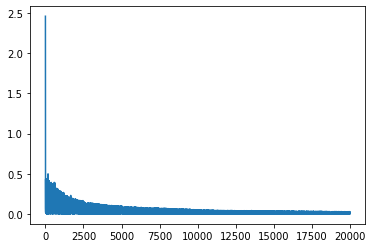

In [17]:
plt.plot(deltas)
plt.show()

In [0]:
# obtain predicted values
V = {}
states = grid.all_states()
for s in states:
  if s in grid.actions:
    V[s] = model.predict(s)
  else:
    # terminal state or state we can't otherwise get to
    V[s] = 0

In [19]:
print("values:")
print_values(V, grid)
print("policy:")
print_policy(policy, grid)

values:
---------------------------
 0.73| 0.83| 0.92| 0.00|
---------------------------
 0.63| 0.00|-0.09| 0.00|
---------------------------
 0.52|-0.29|-1.09|-1.90|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  U  |
